In [1]:
import os
# import scvi
import rpy2
# import scib
import json
# import scgen
# import torch
import anndata
import logging
import warnings
# import scanorama
import anndata2ri
import matplotlib
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from scipy.sparse import csr_matrix
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
decoupler                   1.4.0
executing                   1.2.0
google                      NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite                    0.40.1rc1
louvain                     0.8.0
markupsafe                  2.1.3
matplotlib                  3.7.1
mp

In [4]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(Seurat)
    library(tibble)
    library(magrittr) # needs to be run every time you start R and want to use %>%
})



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

# 1. Reading in the data

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
save_prefix = 'seaad_mtg'
get_cell_types = True

adata_annot = sc.read_h5ad(f'../data/raw/{save_prefix}/{save_prefix}_raw_anndata.h5ad')

if 'counts' not in adata_annot.layers.keys():
    adata_annot.layers['counts'] = adata_annot.X.copy()
else:
    adata_annot.X = adata_annot.layers['counts'].copy()

adata_annot


AnnData object with n_obs × n_vars = 154368 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in mon

In [6]:

subject_ids_for_study = {'allen_mtg': 'individualID',
                        'leng_sfg': 'PatientID',
                        'leng_etc': 'PatientID',
                        'seaad_mtg': 'individualID'}

subject_id = subject_ids_for_study[save_prefix]     # for leng this is `PatientID` for mathys is 'Subject', and allen is subject_id

metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' 

meta = pd.read_csv(metadata, encoding_errors='ignore')
meta = meta.astype(str)
mapping = dict(zip(meta[subject_id], meta['pathology.group']))
adata_annot.obs['pathology.group'] = adata_annot.obs[subject_id].map(mapping)

#adata_annot.X = csr_matrix(adata_annot.layers['counts'].toarray())

In [7]:
celltypes = ["Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC"] 
#"Excitatory", "Inhibitory", "Astrocyte", "Microglia", "Oligodendrocyte", "OPC", "Endothelial"

mapping = {'leng_etc':
           
           {'Exc': 'Excitatory', 
            'Inh': 'Inhibitory', 
            'Astro': 'Astrocyte',
            'Endo': 'Endothelial', 
            'Micro': 'Microglia', 
            'OPC': 'OPC', 
            'Oligo': 'Oligodendrocyte'},

           'leng_sfg':
           
           {'Exc': 'Excitatory', 
            'Inh': 'Inhibitory', 
            'Astro': 'Astrocyte',
            'Endo': 'Endothelial', 
            'Micro': 'Microglia', 
            'OPC': 'OPC', 
            'Oligo': 'Oligodendrocyte'},
           
           'allen_mtg':
           
           {'Excitatory': 'Excitatory', 
            'Inhibitory': 'Inhibitory',
            'Astrocyte': 'Astrocyte',
            'Microglia': 'Microglia', 
            'Endothelial': 'Endothelial', 
            'OPC': 'OPC',
            'Oligodendrocyte': 'Oligodendrocyte'},
            
            'seaad_mtg':
           
           {'Excitatory': 'Excitatory', 
            'Inhibitory': 'Inhibitory',
            'Astrocyte': 'Astrocyte',
            'Microglia': 'Microglia', 
            'Endothelial': 'Endothelial', 
            'OPC': 'OPC',
            'Oligodendrocyte': 'Oligodendrocyte'},
            }

cell_column = {'leng_etc': 'clusterCellType',
               'leng_sfg': 'clusterCellType',
               'allen_mtg': 'cell_labels',
               'seaad_mtg': 'cell_type',
               }

In [8]:
if get_cell_types:
    adata_annot.obs['cell_type'] = adata_annot.obs[cell_column[save_prefix]].map(mapping[save_prefix])

adata_annot = adata_annot[adata_annot.obs.cell_type.isin(celltypes)]

In [9]:
adata_annot

View of AnnData object with n_obs × n_vars = 154189 × 36601
    obs: 'sample_id', 'Neurotypical reference', 'Donor ID', 'Organism', 'Brain Region', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOC

## **Pseduo-bulk Differential Expression Analysis with DESeq2 and EdgeR**

Although we have previously estimated the differentially expressed genes using `MAST` in Seurat, we furthure employ both, pseudobulk methods with sum aggregation such as `edgeR` and `DESeq2`, and ultimately compare the results with those from the mixed models in `MAST`.


Pseudo-bulk methods are originally designed for bulk gene expression data. It implements a wide range of statistical methodology based on the negative binomial distribution, empirical Bayes estimation, exact tests, generalized linear models (GLMs) and quasi-likelihood tests, whereas, the cell-level view models cells ndividually using generalized mixed effect models and as a result. single-cell-specific methods are found to systematically underestimate the variance of gene expression and to be prone to wrongly labelling highly expressed genes as differentially expressed.

This could in turn affect the true positive rate (TPR) and precision. This is becasue `Pseudoreplication leads to an inflated false discovery rate (FDR) as DGE methods do not account for the inherent correlation of replicates (cells from the same individual)`. |Within-sample correlation should be accounted for by aggregating cell-type-specific counts within an individual before DGE analysis.

Here, we showcase use decoupler (to create pseudobulks) and pyDESeq2 (for bulk RNA-seq differential expression analysis)

### **Generate Pseudo-bulks**


Here we perform differential expression analysis between conditions within particular cell types. `DEA can be performed at the single-cell level, but the obtained p-values are often inflated as each cell is treated as a sample.` We know that single cells within a sample are not independent of each other, since they were isolated from the same environment. If we treat cells as samples, we are not testing the variation across a population of samples, rather the variation inside an individual one. Moreover, if a sample has more cells than another it might bias the results.

The current best practice to correct for this is using a pseudo-bulk approach (Squair J.W., et al 2021), which involves the following steps:

- Subsetting the cell type(s) of interest to perform DEA.

- Extracting their raw integer counts.

- Summing their counts per gene into a single profile if they pass quality control.

- Performing DEA if at least two biological replicates per condition are available (more replicates are recommended).


We can pseudobulk using the function `decoupler.get_pseudobulk`. Here, we are interested in `summing the counts` but other modes are available, please see documentation

In [10]:
NUM_OF_CELL_PER_DONOR = 30

import random

def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [11]:
adata = adata_annot.copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()

mapping = dict(zip(meta[subject_id], meta['pathology.group']))
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")


covariates = {'leng_etc': ['pathology.group', 'pmi', 'age_death', 'SampleBatch', 'BraakStage'],
              'leng_sfg': ['pathology.group', 'pmi', 'age_death', 'SampleBatch', 'BraakStage'],
              'seaad_mtg': ['pathology.group', 'PMI', 'Age at Death', 'APOE4 Status', 'Race']}

for covariate in covariates[save_prefix]:
    adata.obs[covariate] = adata.obs[subject_id].map(dict(zip(meta[subject_id], meta[covariate])))
    adata.obs[covariate] = adata.obs[covariate].astype('category')

In [12]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs[subject_id], adata.obs["pathology.group"])
]
adata.obs["sample"] = adata.obs["sample"].astype("category")

In [13]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]

print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata,
                                cell_identity = cell_type,
                                donor_key="sample",
                                condition_key="pathology.group",
                                cell_identity_key="cell_type",
                                obs_to_keep=covariates[save_prefix] + ["sample", 'cell_type'],  # which additional metadata to keep, e.g. gender, age, etc
                                replicates_per_patient=1,)

for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata,
                                           cell_identity = cell_type,
                                           donor_key="sample",
                                           condition_key="pathology.group",
                                           cell_identity_key="cell_type",
                                           obs_to_keep= covariates[save_prefix] + ["sample", 'cell_type'],  # which additional metadata to keep, e.g. gender, age, etc
                                           replicates_per_patient=1,)
    
    adata_pb = anndata.concat([adata_pb, adata_cell_type])
    

Processing Astrocyte (1 out of 6)...
	Processing donor 10 out of 10...

Processing Excitatory (2 out of 6)...
	Processing donor 10 out of 10...

Processing Inhibitory (3 out of 6)...
	Processing donor 10 out of 10...

Processing Microglia (4 out of 6)...
	Processing donor 10 out of 10...

Processing OPC (5 out of 6)...
	Processing donor 10 out of 10...

Processing Oligodendrocyte (6 out of 6)...
	Processing donor 10 out of 10...



In [14]:
# # Get pseudo-bulk profile
# pdata = dc.get_pseudobulk(adata_annot,
#                           sample_col=subject_id,
#                           groups_col='cell_type',
#                           layer='counts',
#                           mode='sum',
#                           min_cells=0,
#                           min_counts=0
#                          )
pdata = adata_pb
pdata

AnnData object with n_obs × n_vars = 60 × 33694
    obs: 'pathology.group', 'pmi', 'age_death', 'SampleBatch', 'BraakStage', 'sample', 'cell_type'

In [15]:
pdata.layers['counts'] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e6)
sc.pp.log1p(pdata)
sc.pp.pca(pdata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


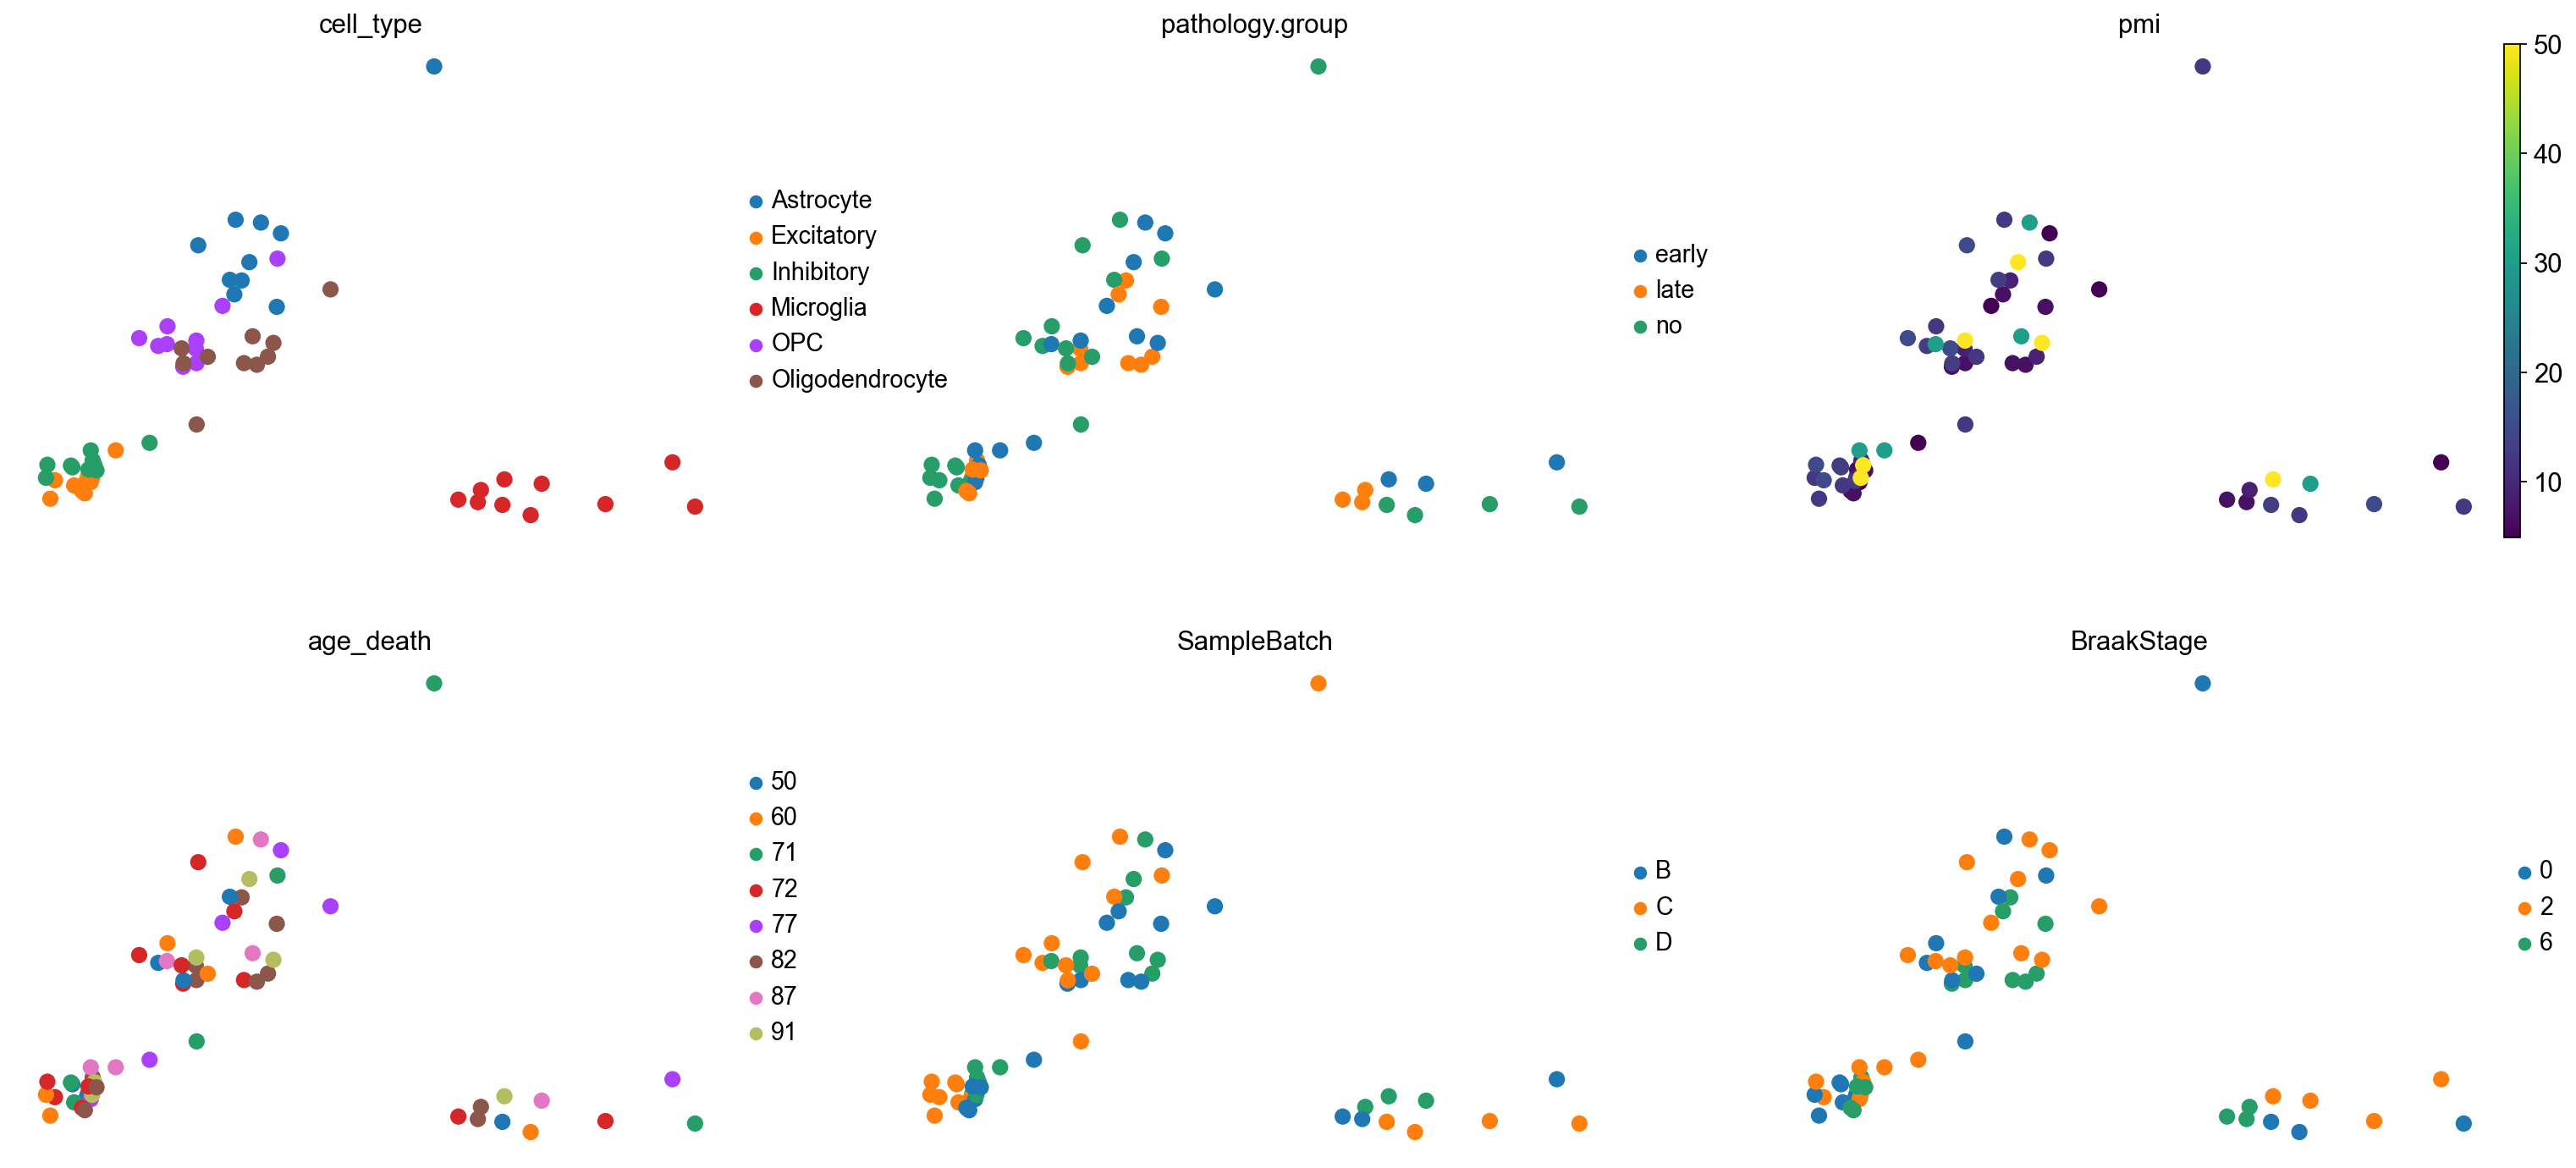

In [16]:
sc.set_figure_params(scanpy=True,
                    dpi_save=300, frameon=False, 
                    vector_friendly=True, fontsize=14, figsize=(7, 5), 
                    color_map=None, format='pdf', facecolor=None,
                    transparent=False, ipython_format='png2x')
                     
                     
pdata.obs['pmi'] = pdata.obs['pmi'].astype('float')


dat_dir = f'figures/pca/'

if not os.path.exists(dat_dir):
    os.makedirs(dat_dir)

sc.pl.pca(pdata[pdata.obs.cell_type.isin(celltypes)], color=['cell_type'] + covariates[save_prefix],
         ncols=3, size=300, save=f'/{save_prefix}_pca_covariates.pdf', components=['2,3'])

# os.rename(f'figure/pca/{save_prefex}.pdf', '../results/figures/pca/{save_prefix}_pca_covariates.pdf')

It has generated a profile for each sample and cell type. We can plot their quality control metrics:

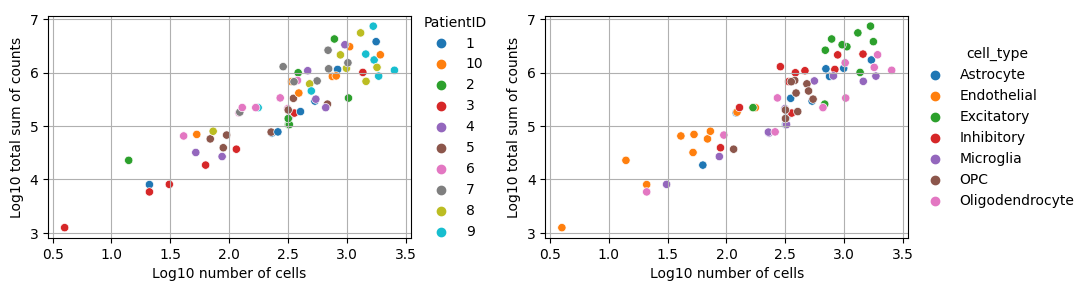

In [9]:
#from decoupler.plotting import plot_psbulk_samples

dc.plot_psbulk_samples(pdata, groupby=['PatientID', 'cell_type'], figsize=(11, 3), )

There are two criteria to filter low quality samples: its number of cells `(psbulk_n_cells)`, and its total sum of counts `(psbulk_counts)`. 

In these plots it can be seen that there are some samples of `Endothelial cells` that contain less than 10 cells, we remove them by using the arguments `min_cells` and `min_counts`. 

These thresholds are arbitrary and will change depening on the dataset, but a good rule of thumb is to have at least `10 cells with 1000 accumulated count`.

In [10]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(adata_annot,
                          sample_col='PatientID',
                          groups_col='cell_type',
                          layer='counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 69 × 16585
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

Additionally, we also filter noisy expressed genes in case we want to perform downstream analyses such as DEA afterwards. This step is done at the cell type level, since each cell type may express different collection of genes.


To filter genes, we follow the strategy implemented in the function `filterByExpr from edgeR`. It keeps genes that have a minimum total number of reads across samples `(min_total_count)`, and that have a minimum number of counts in a number of samples `(min_count)`.


We can plot how many genes to keep by changing the `min_count` and `min_total_count` to check how many genes would be kept when changed


Astrocyte...
Endothelial...
Excitatory...
Inhibitory...
Microglia...
OPC...
Oligodendrocyte...


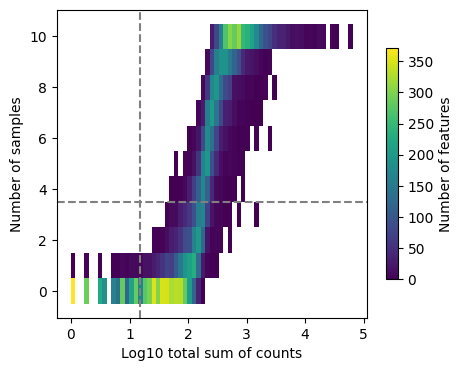

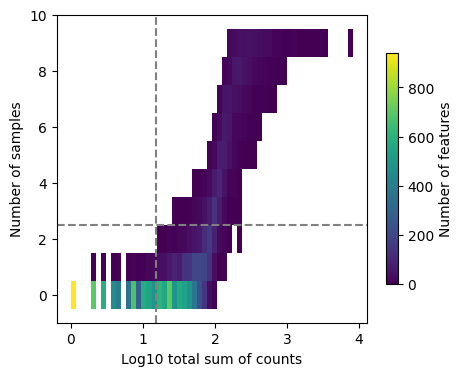

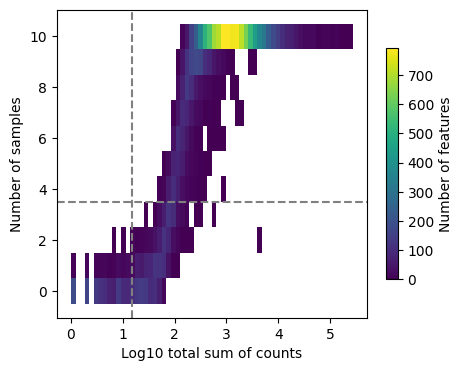

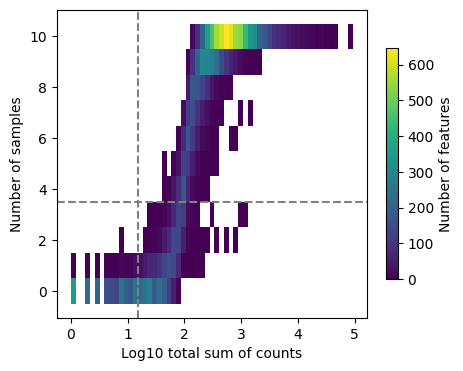

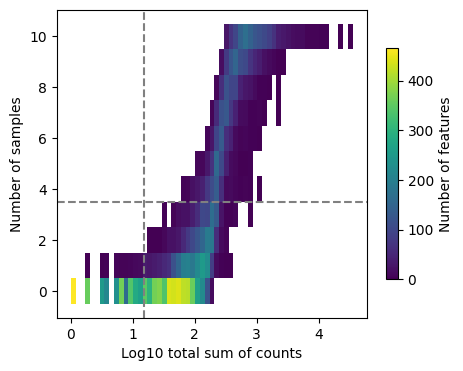

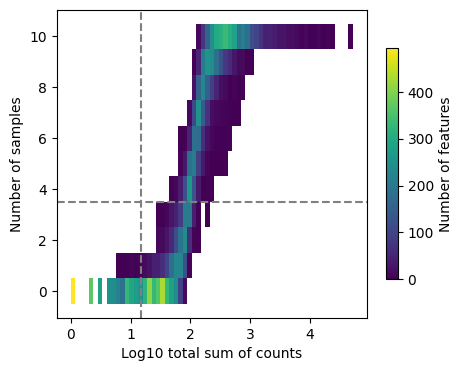

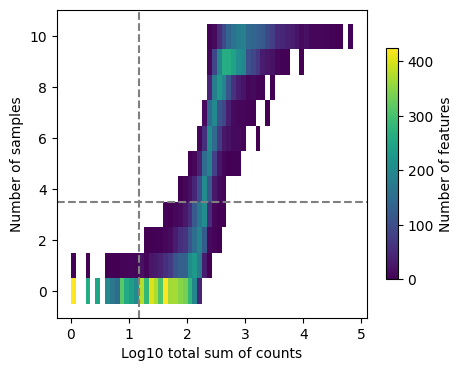

In [11]:
for cell_type in pdata.obs.cell_type.unique():
    temp = pdata[pdata.obs['cell_type'] == cell_type].copy()
    print(f'{cell_type}...')
    dc.plot_filter_by_expr(temp, group='disease_group',
                        min_count=10, min_total_count=15)


Here we can observe the frequency of genes with different total sum of counts and number of samples. With the default values we would keep a good quantity of genes while filtering potential noisy genes.

Next, we perform the actual filtering:

In [12]:
adata_sub = {}

for cell_type in pdata.obs.cell_type.unique():

    print(f'filtering genes in {cell_type}...')
    adata_sub[cell_type] = pdata[pdata.obs['cell_type'] == cell_type].copy()

    # Obtain genes that pass the thresholds
    # genes = dc.filter_by_expr(adata_sub[cell_type], group='disease_group', min_count=10, min_total_count=15)
    genes = dc.filter_by_prop(adata_sub[cell_type], min_prop=0.05)

    # Filter by these genes
    adata_sub[cell_type] = adata_sub[cell_type][:, genes].copy()
    print(adata_sub[cell_type])
    print('\n')

filtering genes in Astrocyte...
AnnData object with n_obs × n_vars = 10 × 6207
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Endothelial...
AnnData object with n_obs × n_vars = 9 × 7734
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Excitatory...
AnnData object with n_obs × n_vars = 10 × 10094
    obs: 'SampleID', 'PatientID', 'BrainRegion', 'BraakStage', 'SampleBatch', 'cell_type', 'predicted_doublet', 'pathology.group', 'disease_group', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'


filtering genes in Inhibitory...
AnnData object with n_obs × n_vars = 10 × 8783
    obs: 'SampleID', 'PatientID', 'BrainRegion'

Another filtering strategy is to filter out genes that are not expressed in a percentage of cells and samples, as implemented in `decoupler.filter_by_prop`.



### **Contrast between conditions**

Now, using the robust pseudo-bulk profiles we generated, we next compute DEA. 

Here, we will use a simple design matrix where we compare the gene expression in each cell-type from diseased patients against controls. We use the python implementation of the framework `DESeq2`. We provide optionality to include more complex experimental designs by adding more factors to the design_factors argument.



In [13]:
dds = {}
stat_res = {}
results = {}

for key in adata_sub.keys():# Build DESeq2 object
    print(f'ESTIMATING CHANGES IN {key.capitalize()}....')
    dds[key] = DeseqDataSet(
        adata=adata_sub[key],
        design_factors=['disease_group'],
        tested_level = ['disease_group', 'ad'],
        refit_cooks=True,
        n_cpus=8,
        )
    # Compute LFCs
    dds[key].deseq2()

    # Extract contrast between AD vs normal
    stat_res[key] = DeseqStats(dds[key], contrast=["disease_group", 'ad', 'no'], n_cpus=8)
    
    # Compute Wald test
    stat_res[key].summary()

    # Shrink LFCs
    stat_res[key].lfc_shrink(coeff='disease_group_ad_vs_no')

    # Extract results
    results[key] = stat_res[key].results_df


ESTIMATING CHANGES IN Astrocyte....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.55 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 3.75 seconds.

Fitting LFCs...
... done in 0.28 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.16 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,13.791571,1.131402,0.657208,1.721527,0.085155,0.225769
AAAS,14.494428,-0.538177,0.409046,-1.315689,0.188278,0.377654
AAGAB,13.437780,0.388463,0.433330,0.896460,0.370007,0.582283
AAK1,60.212410,0.288889,0.248904,1.160647,0.245785,0.449550
AAMDC,20.839342,0.474299,0.429824,1.103473,0.269822,0.479537
...,...,...,...,...,...,...
ZSWIM8,36.409431,-0.738653,0.358589,-2.059886,0.039409,0.136949
ZXDC,31.521423,0.957558,0.368262,2.600207,0.009317,0.051438
ZYG11B,26.798878,-0.238384,0.217927,-1.093871,0.274011,0.483696
ZZEF1,24.067583,-0.250021,0.286234,-0.873485,0.382399,0.591048


Fitting MAP LFCs...
... done in 0.70 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2ML1,13.791571,0.502493,0.639606,1.721527,0.085155,0.225769
AAAS,14.494428,-0.332983,0.396357,-1.315689,0.188278,0.377654
AAGAB,13.437780,0.225119,0.402684,0.896460,0.370007,0.582283
AAK1,60.212410,0.232296,0.242299,1.160647,0.245785,0.449550
AAMDC,20.839342,0.274983,0.411984,1.103473,0.269822,0.479537
...,...,...,...,...,...,...
ZSWIM8,36.409431,-0.547713,0.356012,-2.059886,0.039409,0.136949
ZXDC,31.521423,0.757378,0.368062,2.600207,0.009317,0.051438
ZYG11B,26.798878,-0.144270,0.903363,-1.093871,0.274011,0.483696
ZZEF1,24.067583,-0.186661,0.277001,-0.873485,0.382399,0.591048


ESTIMATING CHANGES IN Endothelial....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.25 seconds.

Fitting dispersion trend curve...
... done in 1.09 seconds.

Fitting MAP dispersions...
... done in 3.56 seconds.

Fitting LFCs...
... done in 0.36 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.26 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,1.183020,1.830383,2.212510,0.827288,0.408074,NaN
A2M,28.197435,0.977012,0.480404,2.033728,0.041979,0.332138
A4GALT,3.368488,1.482371,1.033395,1.434467,0.151439,0.516245
AAAS,1.889470,-0.531725,0.942996,-0.563867,0.572844,NaN
AAGAB,1.894778,1.574061,1.426713,1.103278,0.269906,NaN
...,...,...,...,...,...,...
ZXDC,3.995847,1.072657,0.989142,1.084431,0.278174,0.638962
ZYG11B,5.019523,-0.017867,0.674152,-0.026503,0.978856,0.995970
ZYX,4.718576,-0.134704,0.876397,-0.153702,0.877844,0.968234
ZZEF1,3.443883,0.893623,0.985405,0.906858,0.364482,0.709360


Fitting MAP LFCs...
... done in 0.66 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,1.183020,0.108885,1.020908,0.827288,0.408074,NaN
A2M,28.197435,0.567567,0.481726,2.033728,0.041979,0.332138
A4GALT,3.368488,-0.144270,0.922095,1.434467,0.151439,0.516245
AAAS,1.889470,-0.075996,0.769868,-0.563867,0.572844,NaN
AAGAB,1.894778,0.193520,0.826720,1.103278,0.269906,NaN
...,...,...,...,...,...,...
ZXDC,3.995847,0.186865,0.702189,1.084431,0.278174,0.638962
ZYG11B,5.019523,-0.004277,0.554297,-0.026503,0.978856,0.995970
ZYX,4.718576,-0.022300,0.614432,-0.153702,0.877844,0.968234
ZZEF1,3.443883,0.152491,0.692461,0.906858,0.364482,0.709360


ESTIMATING CHANGES IN Excitatory....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 5.68 seconds.

Fitting dispersion trend curve...
... done in 1.39 seconds.

Fitting MAP dispersions...
... done in 6.30 seconds.

Fitting LFCs...
... done in 0.45 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.26 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,44.668682,0.020055,0.279836,0.071665,0.942868,0.963053
A2ML1,20.431484,1.179092,0.417588,2.823580,0.004749,0.019797
AAAS,34.547066,-0.496257,0.297235,-1.669580,0.095003,0.184667
AACS,186.054672,-0.535067,0.252801,-2.116551,0.034298,0.086644
AADAT,19.925383,0.554362,0.311226,1.781221,0.074876,0.155579
...,...,...,...,...,...,...
ZXDC,105.832764,0.153018,0.161581,0.947007,0.343635,0.477485
ZYG11B,286.587036,-0.608789,0.130697,-4.658034,0.000003,0.000069
ZYX,102.234039,-0.911131,0.259132,-3.516085,0.000438,0.003147
ZZEF1,131.364090,0.097425,0.171297,0.568750,0.569526,0.686472


Fitting MAP LFCs...
... done in 0.95 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,44.668682,0.013565,0.253359,0.071665,0.942868,0.963053
A2ML1,20.431484,0.903650,0.427299,2.823580,0.004749,0.019797
AAAS,34.547066,-0.347830,0.288274,-1.669580,0.095003,0.184667
AACS,186.054672,-0.423984,0.247458,-2.116551,0.034298,0.086644
AADAT,19.925383,0.390588,0.302565,1.781221,0.074876,0.155579
...,...,...,...,...,...,...
ZXDC,105.832764,0.131892,0.157542,0.947007,0.343635,0.477485
ZYG11B,286.587036,-0.577516,0.130092,-4.658034,0.000003,0.000069
ZYX,102.234039,-0.796982,0.260978,-3.516085,0.000438,0.003147
ZZEF1,131.364090,0.082165,0.165917,0.568750,0.569526,0.686472


ESTIMATING CHANGES IN Inhibitory....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.66 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 5.31 seconds.

Fitting LFCs...
... done in 0.43 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.23 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,10.940746,0.206659,0.431936,0.478449,0.632331,0.774623
A2ML1,9.434161,1.435047,0.639399,2.244369,0.024809,0.092151
AAAS,15.078306,0.153943,0.478480,0.321734,0.747654,0.857332
AACS,25.804523,-0.685894,0.262622,-2.611721,0.009009,0.045359
AADAT,10.221308,0.137069,0.359987,0.380760,0.703381,0.827328
...,...,...,...,...,...,...
ZXDC,28.957560,0.236890,0.312515,0.758011,0.448444,0.628037
ZYG11B,115.081406,-0.553080,0.177552,-3.115028,0.001839,0.014792
ZYX,24.516003,-0.591976,0.312186,-1.896230,0.057930,0.163932
ZZEF1,42.280422,-0.091955,0.130885,-0.702565,0.482327,0.657028


Fitting MAP LFCs...
... done in 0.83 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,10.940746,0.082726,0.341945,0.478449,0.632331,0.774623
A2ML1,9.434161,0.640664,0.684271,2.244369,0.024809,0.092151
AAAS,15.078306,0.049691,0.369208,0.321734,0.747654,0.857332
AACS,25.804523,-0.543735,0.264080,-2.611721,0.009009,0.045359
AADAT,10.221308,0.065003,0.305999,0.380760,0.703381,0.827328
...,...,...,...,...,...,...
ZXDC,28.957560,0.133333,0.278285,0.758011,0.448444,0.628037
ZYG11B,115.081406,-0.486515,0.178691,-3.115028,0.001839,0.014792
ZYX,24.516003,-0.392895,0.305295,-1.896230,0.057930,0.163932
ZZEF1,42.280422,-0.080432,0.127505,-0.702565,0.482327,0.657028


ESTIMATING CHANGES IN Microglia....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.35 seconds.

Fitting dispersion trend curve...
... done in 0.63 seconds.

Fitting MAP dispersions...
... done in 2.63 seconds.

Fitting LFCs...
... done in 0.23 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.13 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,77.610939,0.144943,0.636198,0.227826,0.819781,0.925459
AAK1,79.472870,-0.258564,0.277314,-0.932387,0.351137,0.630436
AAMDC,6.965267,0.865581,0.639022,1.354539,0.175565,NaN
AASDH,12.074767,-0.827493,0.309495,-2.673689,0.007502,0.069981
AATF,10.063831,0.039049,0.432051,0.090380,0.927985,0.976715
...,...,...,...,...,...,...
ZSWIM8,13.535036,-1.199485,0.326980,-3.668369,0.000244,0.005693
ZXDC,13.348050,0.653099,0.534948,1.220865,0.222137,0.502183
ZYG11B,13.028562,0.242415,0.424046,0.571673,0.567544,0.791092
ZZEF1,15.806784,-0.512984,0.313057,-1.638627,0.101291,0.326190


Fitting MAP LFCs...
... done in 0.39 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2M,77.610939,0.047517,0.471403,0.227826,0.819781,0.925459
AAK1,79.472870,-0.187475,0.262925,-0.932387,0.351137,0.630436
AAMDC,6.965267,0.352931,0.554242,1.354539,0.175565,NaN
AASDH,12.074767,-0.660988,0.323534,-2.673689,0.007502,0.069981
AATF,10.063831,0.020235,0.413030,0.090380,0.927985,0.976715
...,...,...,...,...,...,...
ZSWIM8,13.535036,-1.038929,0.341123,-3.668369,0.000244,0.005693
ZXDC,13.348050,0.305838,0.476413,1.220865,0.222137,0.502183
ZYG11B,13.028562,0.128378,0.389113,0.571673,0.567544,0.791092
ZZEF1,15.806784,-0.369102,0.315924,-1.638627,0.101291,0.326190


ESTIMATING CHANGES IN Opc....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.49 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 3.84 seconds.

Fitting LFCs...
... done in 0.26 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.16 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,65.337326,-0.213477,0.243061,-0.878289,0.379787,0.578555
AAMDC,14.311963,0.966979,0.323980,2.984692,0.002839,0.018467
AASDH,22.047436,0.379225,0.302567,1.253358,0.210076,0.399578
AASDHPPT,13.085230,-0.251250,0.292100,-0.860150,0.389706,0.586632
AASS,29.962469,1.210217,0.337980,3.580731,0.000343,0.003365
...,...,...,...,...,...,...
ZSWIM8,20.701534,-0.996870,0.353697,-2.818433,0.004826,0.027718
ZXDC,17.757294,0.099294,0.251804,0.394330,0.693337,0.833059
ZYG11B,27.754816,-0.668591,0.182222,-3.669105,0.000243,0.002569
ZZEF1,13.951694,0.577084,0.389316,1.482302,0.138260,0.301614


Fitting MAP LFCs...
... done in 0.57 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,65.337326,-0.167066,0.232435,-0.878289,0.379787,0.578555
AAMDC,14.311963,-0.144270,0.733519,2.984692,0.002839,0.018467
AASDH,22.047436,0.275032,0.290344,1.253358,0.210076,0.399578
AASDHPPT,13.085230,-0.179488,0.283262,-0.860150,0.389706,0.586632
AASS,29.962469,1.053475,0.336428,3.580731,0.000343,0.003365
...,...,...,...,...,...,...
ZSWIM8,20.701534,-0.805206,0.354631,-2.818433,0.004826,0.027718
ZXDC,17.757294,0.074418,0.243589,0.394330,0.693337,0.833059
ZYG11B,27.754816,-0.144270,0.733519,-3.669105,0.000243,0.002569
ZZEF1,13.951694,0.373671,0.369688,1.482302,0.138260,0.301614


ESTIMATING CHANGES IN Oligodendrocyte....
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.58 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 3.10 seconds.

Fitting LFCs...
... done in 0.26 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 0.14 seconds.

Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,73.290947,0.438805,0.294575,1.489618,0.136325,0.307152
AAMDC,24.649813,0.381835,0.246706,1.547734,0.121686,0.286598
AASDH,18.823017,0.271993,0.302241,0.899921,0.368162,0.573432
AASDHPPT,15.762541,0.339242,0.329056,1.030955,0.302562,0.506670
AASS,27.071848,1.015645,0.432169,2.350110,0.018768,0.077851
...,...,...,...,...,...,...
ZSWIM8,23.921637,-0.933255,0.222140,-4.201196,0.000027,0.000494
ZXDC,22.942719,0.802605,0.332170,2.416245,0.015681,0.068200
ZYG11B,24.448322,-0.505264,0.208586,-2.422332,0.015421,0.067389
ZZEF1,20.183048,0.062875,0.350993,0.179136,0.857831,0.923191


Fitting MAP LFCs...
... done in 0.53 seconds.

Shrunk Log2 fold change & Wald test p-value: disease_group ad vs no


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAK1,73.290947,0.334046,0.283649,1.489618,0.136325,0.307152
AAMDC,24.649813,0.309460,0.241783,1.547734,0.121686,0.286598
AASDH,18.823017,0.196790,0.288883,0.899921,0.368162,0.573432
AASDHPPT,15.762541,0.236210,0.315320,1.030955,0.302562,0.506670
AASS,27.071848,0.736553,0.432354,2.350110,0.018768,0.077851
...,...,...,...,...,...,...
ZSWIM8,23.921637,-0.859692,0.224257,-4.201196,0.000027,0.000494
ZXDC,22.942719,0.638835,0.324024,2.416245,0.015681,0.068200
ZYG11B,24.448322,-0.442755,0.208335,-2.422332,0.015421,0.067389
ZZEF1,20.183048,0.040876,0.322888,0.179136,0.857831,0.923191


In [20]:
results['Excitatory'].sort_values(by='padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MROH1,234.493439,-0.988464,0.081289,-12.287118,1.062259e-34,1.069376e-30
BAIAP2L1,88.800751,1.840607,0.160665,11.670178,1.810448e-31,9.112891e-28
TRIM37,298.790588,-0.706565,0.061838,-11.543684,7.944830e-31,2.666020e-27
SLC47A1,54.251484,1.601262,0.149284,10.873065,1.549070e-27,3.898621e-24
ST18,93.357063,2.438337,0.235061,10.592783,3.218761e-26,6.480653e-23
...,...,...,...,...,...,...
SERTAD2,86.723549,-0.682316,0.574784,-2.178126,NaN,NaN
SOWAHA,48.458488,-0.228095,0.460524,-1.124090,NaN,NaN
TET3,276.497803,-0.810933,0.560163,-2.399759,NaN,NaN
TIPARP,25.076988,-0.280703,0.583518,-1.677823,NaN,NaN


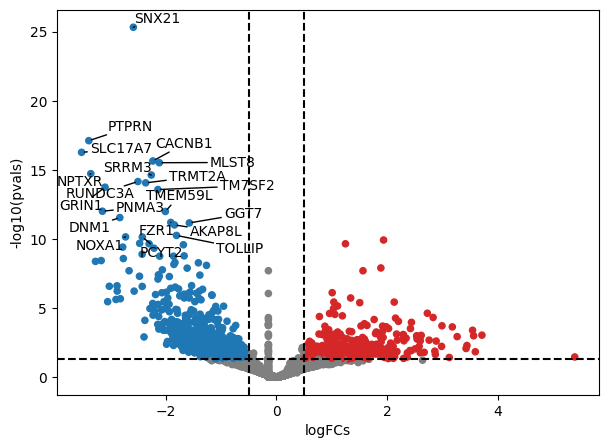

In [17]:
dc.plot_volcano_df(results['Astrocyte'], x='log2FoldChange', y='padj', top=20)


In [19]:
adata_sub['Astrocyte'].layers['psbulk_props'].shape

(10, 6207)